## Initial plan for training an SAE on spikes and trying to find interpretable SAE features

- [x] Get neural + behavioral data
  - [x] Get Allen visual coding neuropixels spikes data
  - [x] Get Allen visual stim data + metadata
- Train SAEs 
  - [x] Break spikes down into time windows
  - [x] Train SAEs on all spikes for a particular region for all sessions for one animal
- [x] Interpret SAE features
  - [x] After training, feed in spikes for particular time window(s) and see which SAE feature(s) fire, and see if they correspond to the visual stim
- Validate SAEs
  - [x] Visualize reconstructions
  - [x] Validate reconstructions (e.g. cosine similarity between reconstructions and true spikes)
  - [x] Validate sparsity (% active features over % time active)


## Example MINI pipeline on new data:

- Train/val/test split
- Train + hyperparam sweep SAE with k-fold crossval
- Validate SAE (on train + val data)
    - Validate that SAE features are sparse
      - Histogram of L0 (prob active for % of active features)
    - Validate that reconstructions are good
      - $R^2$ for total number of spikes summed over all neurons for each example
      - Cosine similarity for vector of reconstructions to vector of actual for each example
- Find k top-ranked SAE features (e.g. features with the highest mean N activation values, or features that are most important to reconstruction (i.e. when removed, reconstruction suffers the most) )
  - For each top-k SAE feature, (semi-automatically?) scour data / metadata to find corresponding natural feature
    - Essentially create a confusion matrix for natural vs. SAE feature: for all occurrences of natural feature, see co-occurrence rate of top-responding SAE features; for all occurrences of SAE feature, see co-occurrence rate of natural feature
- Validate top-k SAE features (on test data)
    - Again create natural vs. SAE feature confusion matrix, as was done above for train + val data
    - Show that the neurons and spikes that contribute to an SAE feature can decode the natural feature:
      - Roughly equivalent to decoding that takes into account *all* spikes ? 
      - OR (only do the following if the above fails) better than
        1. The top n neurons most correlated (highest firing) with the natural feature
        2. And/or the top n neurons that contribute to the SAE feature


### Two types of usecases

1. Given neural and behavioral data, find novel natural features encoded by characteristic neural activity patterns (found via SAE features) - this could be semi-automated

2. Given a set of natural features, find neural activity patterns (via SAE features) that encode them - this could be fully automated! (but is not that different than doing something like a linear bayesian decoder)

## Potential future plans

- Sweeps:
    - Number of SAE features  
    - Time window size
    - Add a seq_len of time windows
    - SAE arch variants
        - Add a second layer to decoder (to capture nonlinear features)
        - Matryoshka SAE (if we suspect feature absorption)
    - Loss function changes
        - L1_coeff values
        - Try non-L1-loss methods to encourage SAE sparsity
            - tanh penalty https://transformer-circuits.pub/2024/feb-update/index.html#dict-learning-tanh
            - topk saes https://cdn.openai.com/papers/sparse-autoencoders.pdf
        - Try folding decoder weight norm into loss: https://transformer-circuits.pub/2024/april-update/index.html#training-saes
    - Different optimizers

- Repeat training for particular regions for multiple animals

- Feature diffing between animals using SCCs?

In [1]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

In [2]:
"""Import packages."""

from dataclasses import dataclass
from IPython.display import Image
from pathlib import Path
from typing import Callable, List, Optional, Tuple, Union

import jax
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import torch as t
from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from rich import print as rprint
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
from torch import bfloat16, nn, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

## Get Allen visual coding neuropixels data

In [ ]:
"""Set paths."""

out_dir = Path(r"C:\Users\jai\mini\data")
out_dir.mkdir(exist_ok=True)
print(f"{out_dir.exists()=}")

manifest_path = out_dir / "manifest.json"
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

out_dir.exists()=True


In [4]:
"""Get metadata."""

units = cache.get_units()
probes = cache.get_probes()
channels = cache.get_channels()
sessions = cache.get_session_table()

In [5]:
display(sessions.head(10))

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"
739448407,2019-10-03T00:00:00Z,716813543,brain_observatory_1.1,112.0,M,wt/wt,625,2221,6,"[grey, VISam, nan, VIS, VISp, VISl, VISrl]"
742951821,2019-10-03T00:00:00Z,723627604,brain_observatory_1.1,120.0,M,wt/wt,893,2219,6,"[VISal, nan, grey, VISl, VISrl, VISp, VISpm, VIS]"
743475441,2019-10-03T00:00:00Z,722882755,brain_observatory_1.1,121.0,M,wt/wt,553,2225,6,"[LP, LGd, HPF, DG, CA3, CA1, VISrl, nan, PP, P..."
744228101,2019-10-03T00:00:00Z,719817805,brain_observatory_1.1,122.0,M,wt/wt,659,2226,6,"[Eth, TH, LP, POL, APN, DG, CA1, VIS, nan, CA3..."


In [6]:
"""Look for animals with multiple sessions."""

bo_df = sessions[sessions["session_type"] == "brain_observatory_1.1"]  # brain observatory data
id_counts = bo_df['specimen_id'].value_counts()
repeated_ids = id_counts[id_counts > 1]
print(f"{repeated_ids=}")

repeated_ids=Series([], Name: specimen_id, dtype: int64)


No animals with more than one session, so we'll just train on single animal-session for now.

In [7]:
"""Choose a session and load in the data."""

# session = sessions[sessions["specimen_id"] == 742951821]
# session = sessions[sessions["specimen_id"] == 750332458]
session = sessions[sessions["specimen_id"] == 717038288]
display(session)
session_id = session.index.values[0]
print(f"{session_id=}")
session_data = cache.get_session_data(session_id)

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"


session_id=732592105


c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Some useful (not exhaustive) `session_data` attributes and methods

- Attributes:
  - metadata
  - channels
  - stimulus_conditions
  - stimulus_presentations
  - spike_times
  - spike_amplitudes

- Methods:
  - channel_structure_intervals
  - conditionwise_spike_statistics
  - get_pupil_data 
  - get_stimulus_epochs
  - get_stimulus_parameter_values
  - get_stimulus_table
  - get_lfp
  - get_screen_graze_data
  - get_invalid_times
  - presentationwise_spike_times
  - presentationwise_spike_counts
  - running_speed

In [8]:
display(session_data.metadata)

c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loa

{'specimen_name': 'C57BL/6J-404553',
 'session_type': 'brain_observatory_1.1',
 'full_genotype': 'wt/wt',
 'sex': 'M',
 'age_in_days': 100.0,
 'rig_equipment_name': 'NP.1',
 'num_units': 824,
 'num_channels': 1847,
 'num_probes': 5,
 'num_stimulus_presentations': 70388,
 'session_start_time': datetime.datetime(2019, 1, 8, 16, 26, 20, tzinfo=tzoffset(None, -28800)),
 'ecephys_session_id': 732592105,
 'structure_acronyms': ['VISpm',
  'grey',
  nan,
  'VISp',
  'VISl',
  'VISal',
  'VISrl'],
 'stimulus_names': ['spontaneous',
  'gabors',
  'flashes',
  'drifting_gratings',
  'natural_movie_three',
  'natural_movie_one',
  'static_gratings',
  'natural_scenes']}

In [9]:
"""Choose a region to select units from, within session, and view probe metadata."""

region = "VISp"

session_channels = session_data.channels.drop(columns=["filtering"])
session_channels_visp = session_channels[session_channels["structure_acronym"] == region]

display(session_channels_visp)

,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
id,,,,,,,,,,
850231405,307,27,733744649,3080,VISp,385.0,VISp,NaN,NaN,NaN
850231359,284,43,733744649,2860,VISp,385.0,VISp,NaN,NaN,NaN
850231385,297,11,733744649,2980,VISp,385.0,VISp,NaN,NaN,NaN
850231343,276,43,733744649,2780,VISp,385.0,VISp,NaN,NaN,NaN
850231389,299,27,733744649,3000,VISp,385.0,VISp,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
850231349,279,27,733744649,2800,VISp,385.0,VISp,NaN,NaN,NaN
850231323,266,59,733744649,2680,VISp,385.0,VISp,NaN,NaN,NaN
850231281,245,11,733744649,2460,VISp,385.0,VISp,NaN,NaN,NaN


In [10]:
"""View units metadata."""

units_df = session_data.units
region_units = units_df[units_df["structure_acronym"] == region]
display(region_units)

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
915960297,0.410785,117.866385,0.001235,335,214.70,3.013238,3.051031,0.089814,50.575739,0.006127,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True
915960294,0.210040,106.159365,0.000761,334,159.52,3.250551,13.198225,0.006399,74.417854,0.002733,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True
915960290,0.248721,131.387490,0.053858,333,491.48,2.292449,5.642346,0.038768,58.246321,0.008143,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True
915960287,0.560337,153.604815,0.034125,332,309.50,3.832008,14.034699,0.005457,67.692919,0.012434,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True
915960283,0.401756,141.322935,0.046545,331,144.15,2.651925,4.370163,0.062538,49.513412,0.009947,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915960975,0.374368,262.344420,0.002301,542,85.86,5.000994,0.543841,0.269217,59.157642,0.000969,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True
915960972,0.487083,126.358635,0.027390,541,358.85,3.163878,0.980188,0.290065,47.377000,0.006576,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True
915960968,0.372298,345.604740,0.001666,539,176.93,8.156430,0.634339,0.000000,95.795791,0.000010,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True


In [11]:
"""Get spikes for units within specified region."""

spike_times = session_data.spike_times
region_unit_ids = set(region_units.index)
region_spike_times = {
    unit_id: spikes
    for unit_id, spikes in spike_times.items()
    if unit_id in region_unit_ids
}
display(region_spike_times)

{915960921: array([  82.15947037,   82.20857039,   83.81880417, ..., 9414.41789664,
        9414.51213   , 9414.63093003]),
 915960683: array([7.43947753e-01, 7.61647758e-01, 1.01491450e+00, ...,
        9.41484863e+03, 9.41497826e+03, 9.41499916e+03]),
 915960678: array([6.36547724e-01, 7.61414425e-01, 8.23247775e-01, ...,
        9.41474240e+03, 9.41482016e+03, 9.41499213e+03]),
 915960674: array([1.77788137e+00, 2.66708162e+00, 2.80251499e+00, ...,
        9.41284170e+03, 9.41297856e+03, 9.41406206e+03]),
 915960812: array([3.83351528e+00, 3.95428198e+00, 7.57101632e+00, ...,
        9.41401743e+03, 9.41470813e+03, 9.41477036e+03]),
 915960810: array([5.40881030e-01, 7.20304955e+00, 7.32741625e+00, ...,
        9.36201422e+03, 9.39398782e+03, 9.40106503e+03]),
 915960586: array([6.35847723e-01, 7.76647762e-01, 8.40514447e-01, ...,
        9.17326470e+03, 9.17328940e+03, 9.17335493e+03]),
 915960835: array([6.30918263e+00, 2.68179550e+01, 2.69210884e+01, ...,
        9.41119550e+03, 

In [12]:
"""See total number of spikes, and the maximum number of spikes in a single unit."""

region_unit_spike_counts = {len(ts) for ts in region_spike_times.values()}
sum(region_unit_spike_counts), max(region_unit_spike_counts)

(6910581, 458062)

Options for feeding in spikes:
- Total spike counts per unit in a small time window

In [13]:
"""Format spikes data for SAE: binned spike counts."""

win = 0.1  # 100 ms
min_max_pairs = [(ts_arr.min(), ts_arr.max()) for ts_arr in region_spike_times.values()]
_first_spike_ts, last_spike_ts = (
    min(pair[0] for pair in min_max_pairs), max(pair[1] for pair in min_max_pairs)
)
_stop_time = session_data.stimulus_presentations.iloc[-1]["stop_time"]

# Get spike counts for all units for each timebin via histogram2d
all_spike_ts = np.concatenate(list(region_spike_times.values()))
unit_indices = np.concatenate(
    [np.full(len(spikes), i) for i, spikes in enumerate(region_spike_times.values())]
)
# note: could have used `first_spike_ts` instead of 0, and `stop_time` instead of `last_spike_ts`
time_bins = np.arange(0, last_spike_ts, win)
unit_bins = np.arange(len(region_spike_times) + 1)
counts, _, _ = np.histogram2d(
    all_spike_ts, unit_indices, bins=[time_bins, unit_bins]
)
counts = t.from_numpy(counts.astype(np.uint8))
n_examples, n_units = counts.shape

In [14]:
"""Check sparsity of binned spike counts."""

frac_nonzero_bins = t.sum(counts > 0) / counts.numel()
spike_counts_per_bin = reduce(counts, "example unit -> example", "sum")
frac_nonzero_examples = sum(spike_counts_per_bin > 0) / spike_counts_per_bin.shape[0]
print(f"{frac_nonzero_bins=}\n{frac_nonzero_examples=}")

frac_nonzero_bins=tensor(0.3095)
frac_nonzero_examples=tensor(0.9997)


In [15]:
"""Convert to sparse tensor."""

# Get nonzero idxs in appropriate format for `sparse_coo_tensor`
idxs = rearrange(t.nonzero(counts), "example orig_coord -> orig_coord example")
vals = counts[idxs[0], idxs[1]]
counts = t.sparse_coo_tensor(idxs, vals, t.Size(counts.shape))
print(counts)

tensor(indices=tensor([[    5,     5,     5,  ..., 94149, 94149, 94149],
                       [    5,    10,    12,  ...,   100,   102,   104]]),
       values=tensor([1, 1, 1,  ..., 2, 2, 7]),
       size=(94150, 110), nnz=3205141, dtype=torch.uint8,
       layout=torch.sparse_coo)


In [16]:
"""View binned spike counts as df."""

counts_df = pd.DataFrame(
    counts.to_dense(),
    columns=region_spike_times.keys(),  # unit IDs as column names
    index=time_bins[:-1],  # bin start times as index
)
display(counts_df)

,915960921,915960683,915960678,915960674,915960812,915960810,915960586,915960835,915960832,915960825,...,915960615,915960297,915960294,915960290,915960287,915960283,915960275,915960262,915960382,915960947
0.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9414.5,1,1,0,0,0,0,0,0,0,0,...,1,0,1,0,6,1,1,0,1,0
9414.6,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,5,1,1,0,2,0
9414.7,0,2,1,0,2,0,0,0,0,0,...,3,0,1,0,9,1,0,0,0,0
9414.8,0,1,1,0,0,0,0,0,0,0,...,1,0,1,0,2,1,1,0,1,0


## Train the SAE

In [17]:
"""Check torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"{device=}")
if device.type == "cuda":
    print(t.cuda.get_device_name(0))

device=device(type='cuda')
NVIDIA GeForce RTX 3090


In [18]:
"""Get amount of free memory in gb in torch device."""

t.cuda.get_device_properties(device).total_memory / 1e9 - (
    (t.cuda.memory_allocated(device) / 1e9) + (t.cuda.memory_reserved(device) / 1e9)
)

25.769279488

In [19]:
"""Estimate gb required for largest tensor op."""

# batch_sz, n_instances, n_units, seq_len, n_hidden_ae = 8, 2, 110, 1, 1_000_000
# [16, 2, 110] @ [2, 110, 1_000_000] -> [16, 2, 1_000_000]
((16 * 2 * 110) + (2 * 110 * 1_000_000) + (16 * 2 * 1_000_000) * 2) / 1e9

0.28400352

In [20]:
"""Create SAE for taking binned spike counts."""

@dataclass
class SaeConfig:
    """Config class to set some params for SAE."""
    n_input_ae: int  # number of input units to the autoencoder
    n_hidden_ae: int = 10_000  # number of hidden units in the autoencoder
    n_instances: int = 2  # number of model instances to optimize in parallel
    l1_coeff: float = 0.0  # relative weight of sparsity_loss : activations_reconstruction_loss


class Sae(nn.Module):
    """SAE model for learning sparse representations of binned spike counts."""
    # Shapes of weights and biases for the encoder and decoder in the single-layer SAE.
    W_enc: Float[Tensor, "inst in_ae hidden_ae"]
    W_dec: Float[Tensor, "inst hidden_ae in_ae"]
    b_enc: Float[Tensor, "inst hidden_ae"]
    b_dec: Float[Tensor, "inst in_ae"]

    def __init__(self, cfg: SaeConfig):
        """Initializes model parameters."""
        super().__init__()
        self.cfg = cfg
        
        self.W_enc = t.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae), dtype=bfloat16)
        self.W_enc = nn.Parameter(nn.init.xavier_normal_(self.W_enc))
        
        self.W_dec = t.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae), dtype=bfloat16)
        self.W_dec = nn.Parameter(nn.init.xavier_normal_(self.W_dec))
        
        self.b_enc = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_hidden_ae), dtype=bfloat16))
        
        self.b_dec = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_input_ae), dtype=bfloat16))

    def forward(self, x: Float[Tensor, "batch inst in_ae"]):
        """Computes loss as a function of SAE feature sparsity and spike_count reconstructions."""
        # Compute encoder hidden activations.
        z = einsum(x, self.W_enc, "batch inst in_ae, inst in_ae hidden_ae -> batch inst hidden_ae")
        z = F.relu(z + self.b_enc)

        # Compute reconstructed input.
        x_prime = (
            einsum(z, self.W_dec, "batch inst hidden_ae, inst hidden_ae in_ae -> batch inst in_ae")
            + self.b_dec
        )

        # Compute loss ( l1_loss (sparsity) and l2_loss (reconstruction) ) 
        l1_loss = reduce(z.abs(), "batch inst hidden_ae -> batch inst", "sum")
        recon_actual_log_ratio = t.log(x_prime / (x + 1e-7))
        l2_loss = reduce(recon_actual_log_ratio.pow(2), "batch inst in_ae -> batch inst", "mean")
        loss = (self.cfg.l1_coeff * l1_loss + l2_loss).mean(0).sum()  # scalar
        return l1_loss, l2_loss, loss, z, x_prime

    @t.no_grad()
    def normalize_decoder(self) -> None:
        """Unit norms the decoder weights."""
        self.W_dec.data = self.W_dec.data / self.W_dec.data.norm(dim=2, keepdim=True)

In [21]:
"""Add method to `Sae` to resample dead neurons."""

@t.no_grad()
def resample_neurons(
    self: Sae,
    frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
) -> Tuple[List[List[str]], str]:  # -> (colors_for_neurons, title_with_resampling_info)
    """Resamples neurons dead for `dead_neuron_window` steps, according to `frac_active`."""
    # Get a tensor of dead neurons.
    dead_features_mask = frac_active_in_window.sum(0) < 1e-8  # -> [n_instances n_hidden_ae]
    n_dead = dead_features_mask.int().sum().item()

    # Get our random replacement values (-> [n_dead n_input_ae]).
    replacement_vals = t.randn((n_dead, self.cfg.n_input_ae), device=self.W_enc.device)
    replacement_vals_norm = replacement_vals / replacement_vals.norm(dim=-1, keepdim=True) + 1e-8

    # Reset W_enc, W_dec, and b_enc (we transpose W_enc to return a view with correct shape).
    self.W_enc.data.transpose(-1, -2)[dead_features_mask] = replacement_vals_norm
    self.W_dec.data[dead_features_mask] = replacement_vals_norm
    self.b_enc.data[dead_features_mask] = 0.0

    # Return data for visualising the resampling process.
    colors = [
        ["red" if dead else "black" for dead in dead_neuron_mask_inst]
        for dead_neuron_mask_inst in dead_features_mask
    ]
    title = f"resampling {n_dead}/{dead_features_mask.numel()} neurons (shown in red)"
    return colors, title

# Add method to sae class.
Sae.resample_neurons = resample_neurons

In [22]:
"""Add `Sae` optimization method."""

def lr_schedule(*_):
    """Simple learning rate schedule."""
    return 1.0

def optimize(
    self: Sae,
    spike_counts: Int[Tensor, "n_examples n_units"],
    seq_len: int = 1,  # number of timebins to use in each spike_count_seq
    batch_sz: int = 16,
    steps: int = 200_000,
    log_freq: int = 1000,
    lr: float = 1e-3,
    lr_scale: Callable[[int, int], float] = lr_schedule,
    neuron_resample_window: Optional[int] = None,  # in optimization steps
):
    """Optimizes the autoencoder using the given hyperparameters."""
    optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

    # Create lists to store data we'll eventually be plotting.
    frac_active_list = []  # fraction of non-zero activations for each neuron (feature)
    data_log = {"frac_active": [], "W_enc": [], "W_dec": [], "titles": [], "colors": []}
    colors = None
    title = "No resampling"

    # Define valid samples for `spike_counts`.
    n_examples, _n_units = spike_counts.shape
    valid_starts = n_examples - seq_len + 1

    progress_bar = tqdm(range(steps))
    for step in progress_bar:
        # Normalize decoder weights at each step to prevent artificially small / sparse
        # features from large decoder weights.
        self.normalize_decoder()

        # Check for dead neurons, and resample them if found.
        if (neuron_resample_window is not None) and ((step + 1) % neuron_resample_window == 0):
            frac_active_in_window = t.stack(frac_active_list[-neuron_resample_window:], dim=0)
            colors, title = self.resample_neurons(frac_active_in_window)

        # Update learning rate.
        step_lr = lr * lr_scale(step, steps)
        for group in optimizer.param_groups:
            group["lr"] = step_lr

        # Get batch of spike counts to feed into SAE.
        start_idxs = t.randint(0, valid_starts, (batch_sz, self.cfg.n_instances))
        # broadcast idxs for each sequence to a new dimension
        seq_idxs = start_idxs.unsqueeze(-1) + t.arange(seq_len)
        spike_count_seqs = spike_counts[seq_idxs]
        spike_count_seqs = rearrange(  # format for Sae
            spike_count_seqs, "batch inst seq unit -> (batch seq) inst unit"
        )

        # Optimize.
        optimizer.zero_grad()
        l1_loss, l2_loss, loss, z, _ = self.forward(spike_count_seqs)
        loss.backward()
        optimizer.step()

        # Calculate the sparsities and add them to the list.
        frac_active = reduce(
            (z.abs() > 1e-8).float(), "batch inst hidden_ae -> inst hidden_ae", "mean"
        )
        frac_active_list.append(asnumpy(frac_active))

        # Display progress bar, and append new values for plotting.
        if step % log_freq == 0 or (step + 1 == steps):
            progress_bar.set_postfix(
                l1_loss=self.cfg.l1_coeff * l1_loss.mean(0).sum().item(),
                l2_loss=l2_loss.mean(0).sum().item(),
                lr=step_lr,
            )
            data_log["W_enc"].append(self.W_enc.detach().cpu())
            data_log["W_dec"].append(self.W_dec.detach().cpu())
            data_log["titles"].append(f"Step {step}/{steps}: {title}")
            data_log["frac_active"].append(frac_active.detach().cpu())
            data_log["colors"].append(colors)

    return data_log

# Add method to SAE class.
Sae.optimize = optimize

In [23]:
"""Train the SAE."""

ae_cfg = SaeConfig(
    n_input_ae=counts.shape[1],
    n_instances=2,
    n_hidden_ae=10_000,
    l1_coeff=0.01,
)
sae = Sae(ae_cfg).to(device)

# spike_counts = counts.to_dense().bfloat16().to(device)
# data_log = sae.optimize(spike_counts=spike_counts, steps=500_000, batch_sz=16, lr=0.02)
# torch.save(sae.state_dict(), Path(r"C:\Users\jai\mini\trained_saes\sae0.pth"))

sae.load_state_dict(t.load(Path(r"C:\Users\jai\mini\trained_saes\sae0.pth")))

C:\Users\jai\AppData\Local\Temp\ipykernel_26488\1173686387.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae.load_state_dict(t.load(Path(r"C:\Users\jai\mini\trained_s

<All keys matched successfully>

## Interpret the SAE features

### SAE features corresponding to full-field flash presentations

In [24]:
"""View visual stim metadata."""

session_stim_data = session_data.get_stimulus_table()

display(session_stim_data)
print(f"Visual stimuli types: {session_stim_data['stimulus_name'].unique()}")
n_nat_imgs = len(
    session_stim_data[session_stim_data["stimulus_name"] == "natural_scenes"]
    ["stimulus_condition_id"].unique()
)
print(f"{n_nat_imgs=}")

,stimulus_block,start_time,stop_time,orientation,contrast,size,spatial_frequency,phase,temporal_frequency,x_position,frame,color,stimulus_name,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,21.579074,81.645874,null,null,null,null,null,null,null,null,null,spontaneous,null,60.066800,0
1,0.0,81.645874,81.879397,45.0,0.8,"[20.0, 20.0]",0.08,"[3644.93333333, 3644.93333333]",4.0,-30.0,null,null,gabors,-20.0,0.233523,1
2,0.0,81.879397,82.129600,90.0,0.8,"[20.0, 20.0]",0.08,"[3644.93333333, 3644.93333333]",4.0,20.0,null,null,gabors,-10.0,0.250203,2
3,0.0,82.129600,82.379803,90.0,0.8,"[20.0, 20.0]",0.08,"[3644.93333333, 3644.93333333]",4.0,40.0,null,null,gabors,30.0,0.250203,3
4,0.0,82.379803,82.630006,45.0,0.8,"[20.0, 20.0]",0.08,"[3644.93333333, 3644.93333333]",4.0,40.0,null,null,gabors,-40.0,0.250203,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70383,14.0,9142.164805,9142.415016,60.0,0.8,"[250.0, 250.0]",0.04,0.75,null,null,null,null,static_gratings,null,0.250210,4806
70384,14.0,9142.415016,9142.665223,30.0,0.8,"[250.0, 250.0]",0.08,0.0,null,null,null,null,static_gratings,null,0.250207,4857
70385,14.0,9142.665223,9142.915430,60.0,0.8,"[250.0, 250.0]",0.32,0.75,null,null,null,null,static_gratings,null,0.250207,4876


Visual stimuli types: ['spontaneous' 'gabors' 'flashes' 'drifting_gratings'
 'natural_movie_three' 'natural_movie_one' 'static_gratings'
 'natural_scenes']
n_nat_imgs=119


In [25]:
display(session_stim_data[session_stim_data["stimulus_name"] == "flashes"])

,stimulus_block,start_time,stop_time,orientation,contrast,size,spatial_frequency,phase,temporal_frequency,x_position,frame,color,stimulus_name,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
3647,1.0,1282.632614,1282.882832,0.0,0.8,"[300.0, 300.0]","[0.0, 0.0]","[0.0, 0.0]",null,null,null,-1.0,flashes,null,0.250218,244
3648,1.0,1284.634334,1284.884540,0.0,0.8,"[300.0, 300.0]","[0.0, 0.0]","[0.0, 0.0]",null,null,null,1.0,flashes,null,0.250205,245
3649,1.0,1286.636014,1286.886217,0.0,0.8,"[300.0, 300.0]","[0.0, 0.0]","[0.0, 0.0]",null,null,null,1.0,flashes,null,0.250203,245
3650,1.0,1288.637634,1288.887855,0.0,0.8,"[300.0, 300.0]","[0.0, 0.0]","[0.0, 0.0]",null,null,null,-1.0,flashes,null,0.250220,244
3651,1.0,1290.639354,1290.889562,0.0,0.8,"[300.0, 300.0]","[0.0, 0.0]","[0.0, 0.0]",null,null,null,1.0,flashes,null,0.250208,245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3792,1.0,1572.875204,1573.125420,0.0,0.8,"[300.0, 300.0]","[0.0, 0.0]","[0.0, 0.0]",null,null,null,-1.0,flashes,null,0.250215,244
3793,1.0,1574.876904,1575.127112,0.0,0.8,"[300.0, 300.0]","[0.0, 0.0]","[0.0, 0.0]",null,null,null,-1.0,flashes,null,0.250208,244
3794,1.0,1576.878604,1577.128807,0.0,0.8,"[300.0, 300.0]","[0.0, 0.0]","[0.0, 0.0]",null,null,null,1.0,flashes,null,0.250203,245


In [26]:
"""Get the final few flash presentations and spike counts at these times."""

round_to = 1  # decimal places to round to (for start time of spike count bin)

flashes = session_stim_data[session_stim_data["stimulus_name"] == "flashes"].iloc[-4:]
display(flashes)

flash_times_dark = []
flash_times_light = []
for _, row in flashes.iterrows():  # get all time bins for each flash
    cur_stim_times = np.unique(np.arange(row["start_time"], row["stop_time"], win).round(round_to))
    if row["color"] < 0:
        flash_times_dark.extend(cur_stim_times)
    else:
        flash_times_light.extend(cur_stim_times)

counts_df.index = np.round(counts_df.index, round_to)
counts_flash_df = counts_df.loc[flash_times_light]
display(counts_flash_df)

,stimulus_block,start_time,stop_time,orientation,contrast,size,spatial_frequency,phase,temporal_frequency,x_position,frame,color,stimulus_name,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
3793,1.0,1574.876904,1575.127112,0.0,0.8,"[300.0, 300.0]","[0.0, 0.0]","[0.0, 0.0]",null,null,null,-1.0,flashes,null,0.250208,244
3794,1.0,1576.878604,1577.128807,0.0,0.8,"[300.0, 300.0]","[0.0, 0.0]","[0.0, 0.0]",null,null,null,1.0,flashes,null,0.250203,245
3795,1.0,1578.880274,1579.130475,0.0,0.8,"[300.0, 300.0]","[0.0, 0.0]","[0.0, 0.0]",null,null,null,1.0,flashes,null,0.250200,245
3796,1.0,1580.881944,1581.132147,0.0,0.8,"[300.0, 300.0]","[0.0, 0.0]","[0.0, 0.0]",null,null,null,-1.0,flashes,null,0.250203,244


,915960921,915960683,915960678,915960674,915960812,915960810,915960586,915960835,915960832,915960825,...,915960615,915960297,915960294,915960290,915960287,915960283,915960275,915960262,915960382,915960947
1576.9,0,0,1,0,0,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0
1577.0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
1577.1,0,0,0,0,0,0,5,0,0,0,...,2,1,2,0,0,0,0,1,0,0
1578.9,0,0,0,0,0,0,3,0,0,0,...,3,0,4,0,0,0,1,0,0,0
1579.0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0
1579.1,0,1,0,0,0,1,2,0,0,0,...,2,0,0,0,0,1,0,1,0,0


In [27]:
"""Get topk SAE features for each of the final few flashes."""

k = 5
topk_feat_idxs_all = []
topk_feat_vals_all = []

# For each flash timebin, get corresponding spike count sequences and run through SAE.
for i, (_, row) in enumerate(counts_flash_df.iterrows()):
    spike_count_seqs = repeat(
        t.from_numpy(row.values).bfloat16().to(device),
        "unit -> batch inst unit",
        batch=1,
        inst=2,
    )
    _l1_loss, _l2_loss, _loss, feat_acts, recon_spk_cts = sae.forward(spike_count_seqs)
    # Quick sanity check that we get a strongly activated SAE feature,
    # and that spike count reconstructions are decent.
    print(f"flash timebin {i+1}:")
    print(f"  max feat act: {t.max(feat_acts).item()}")
    print(f"  max recon spk ct: {t.max(recon_spk_cts).item()}")
    print(f"  max actual spk ct: {spike_count_seqs.max().item()}\n")
    topk_feat_vals, topk_feat_idxs = feat_acts[0, 0, :].topk(k)
    topk_feat_vals_all.append(topk_feat_vals)
    topk_feat_idxs_all.append(topk_feat_idxs)

# See topk features for each flash.
display(topk_feat_idxs_all)

flash timebin 1:
  max feat act: 19.375
  max recon spk ct: 20.0
  max actual spk ct: 22.0

flash timebin 2:
  max feat act: 0.3359375
  max recon spk ct: 0.640625
  max actual spk ct: 2.0

flash timebin 3:
  max feat act: 12.5
  max recon spk ct: 15.0625
  max actual spk ct: 16.0

flash timebin 4:
  max feat act: 12.1875
  max recon spk ct: 14.0625
  max actual spk ct: 15.0

flash timebin 5:
  max feat act: 5.375
  max recon spk ct: 6.1875
  max actual spk ct: 7.0

flash timebin 6:
  max feat act: 12.4375
  max recon spk ct: 15.0
  max actual spk ct: 16.0



[tensor([8785, 5339, 4542, 6517, 4707], device='cuda:0'),
 tensor([4707,    2,    0,    3,    1], device='cuda:0'),
 tensor([8785, 6517, 2397, 5339,  484], device='cuda:0'),
 tensor([8785, 5339, 2397, 2474,  484], device='cuda:0'),
 tensor([8785, 2397, 6653, 4370, 3396], device='cuda:0'),
 tensor([8785, 6517,  484, 2474, 5339], device='cuda:0')]

Found some characteristic SAE features?! =D 

Looks like features 8785 and 5339 might fire for full-field flashes!! Cool :)

Now, let's look at the accuracy of reconstructed spike counts for each neuron for each of these 
flashes.

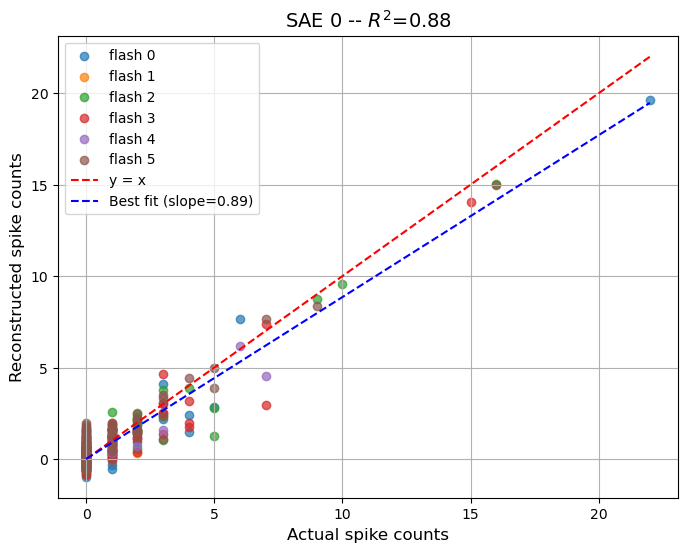

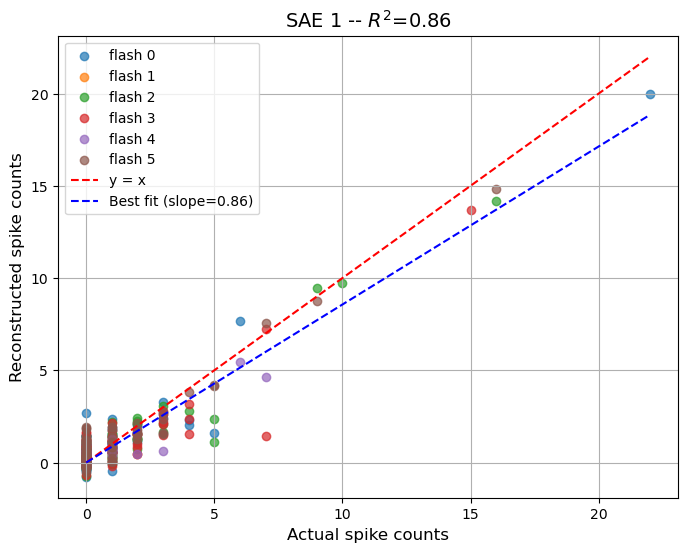

In [28]:
"""View reconstructed over actual spike counts for each neuron for the final few flashes."""

def plot_reconstructed_spike_counts(sae_idx, counts_flash_df, sae_model, device) -> (
    tuple[np.ndarray, plt.Figure]
):
    # Pre-allocate numpy arrays
    n_samples, n_units = len(counts_flash_df), counts_flash_df.shape[1]
    cos_sims = np.empty(n_samples)
    all_actual = np.empty((n_samples, n_units))
    all_recon = np.empty((n_samples, n_units))
    max_ct_spks = 0

    # Initialize figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for i, (_, row) in enumerate(counts_flash_df.iterrows()):
        spike_count_seqs = repeat(
            t.from_numpy(row.values).bfloat16().to(device),
            "n_units -> batch_sz n_instances n_units",
            batch_sz=1,
            n_instances=2,
        )
        _l1_loss, _l2_loss, _loss, _feat_acts, recon_spk_cts = sae_model.forward(spike_count_seqs)
        
        actual = row.values
        recon = asnumpy(recon_spk_cts[0, sae_idx, :].to(t.float32))
        
        all_actual[i] = actual
        all_recon[i] = recon

        ax.scatter(actual, recon, label=f"flash {i}", alpha=0.7)
        max_ct_spks = max(max_ct_spks, actual.max())

        cos_sims[i] = t.cosine_similarity(
            recon_spk_cts[0, sae_idx, :], spike_count_seqs[0, sae_idx, :], dim=0
        ).item()

    # Flatten arrays for regression and R² computation
    all_actual_flat = all_actual.ravel()
    all_recon_flat = all_recon.ravel()
    
    # Compute R² score and get line of best fit
    r2 = r2_score(all_actual_flat, all_recon_flat)
    reg = LinearRegression(fit_intercept=False)
    reg.fit(rearrange(all_actual_flat, "n -> n 1"), all_recon_flat)
    slope = reg.coef_[0]

    # Plot lines
    ax.plot([0, max_ct_spks], [0, max_ct_spks], color="red", linestyle="--", label="y = x")
    ax.plot(
        [0, max_ct_spks], 
        [0, slope * max_ct_spks], 
        color="blue",
        linestyle="--",
        label=f"Best fit (slope={slope:.2f})"
    )

    ax.set_title(f"SAE {sae_idx} -- $R^2$={r2:.2f}", fontsize=14)
    ax.set_xlabel("Actual spike counts", fontsize=12)
    ax.set_ylabel("Reconstructed spike counts", fontsize=12)
    ax.legend()
    ax.grid(True)

    return cos_sims, fig

spk_recon_cos_sims_sae0, _ = plot_reconstructed_spike_counts(0, counts_flash_df, sae, device)
spk_recon_cos_sims_sae1, _ = plot_reconstructed_spike_counts(1, counts_flash_df, sae, device)

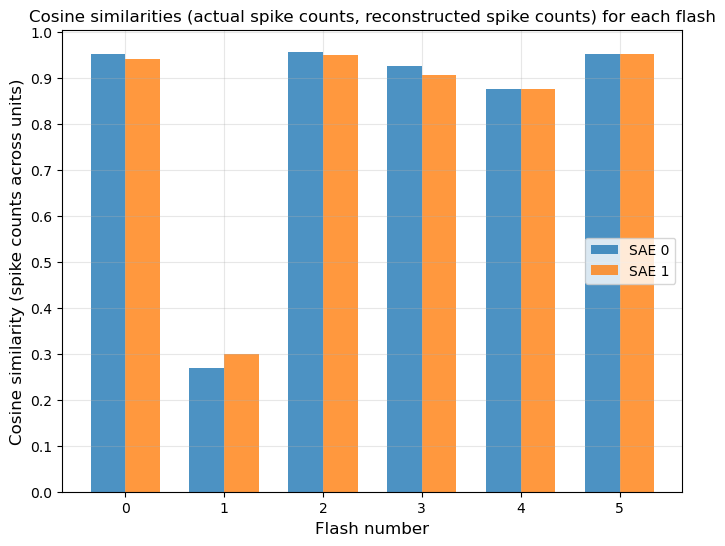

In [29]:
"""View cosine similarities of reconstruction-to-actual spike counts for each of final few flashes.

For each flash, reconstructed and actual spike counts across all neurons are vectors to compare.
"""

x = np.arange(len(spk_recon_cos_sims_sae0))
width = 0.35  # Width of the bars

# Initialize the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Create grouped bars
ax.bar(x - width/2, spk_recon_cos_sims_sae0, width, label="SAE 0", alpha=0.8)
ax.bar(x + width/2, spk_recon_cos_sims_sae1, width, label="SAE 1", alpha=0.8)

# Set titles and labels
ax.set_title(
    "Cosine similarities (actual spike counts, reconstructed spike counts) for each flash"
)
ax.set_xlabel("Flash number", fontsize=12)
ax.set_ylabel("Cosine similarity (spike counts across units)", fontsize=12)
ax.legend(loc="center right")
ax.grid(True, alpha=0.3)

# Set x-ticks to be centered between grouped bars
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.show()

## Validate SAEs

(-0.2, 0.2)

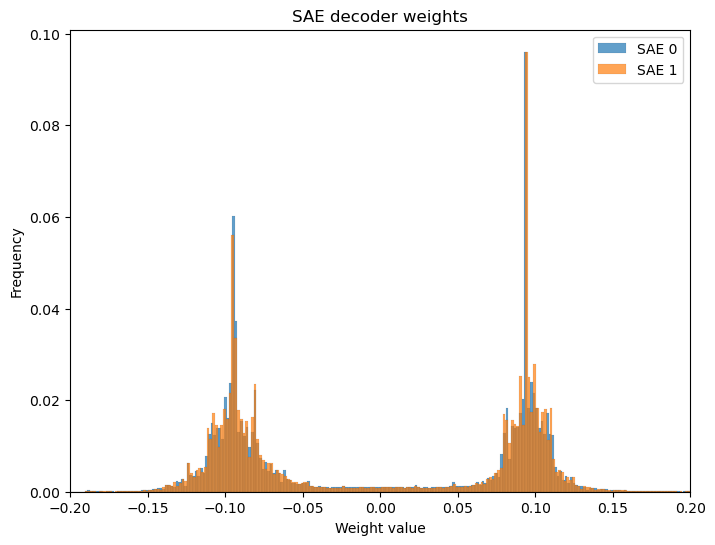

In [30]:
"""Visualize decoder weights."""

n_inst = sae.cfg.n_instances

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sae.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()
ax.set_xlim(-0.2, 0.2)

### Validate feature sparsity (L0)

  0%|          | 0/1471 [00:00<?, ?it/s]

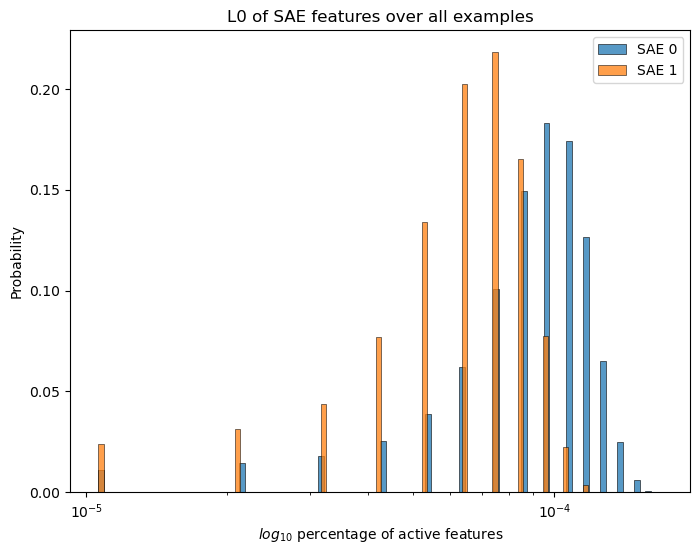

In [31]:
"""Validate SAE feature sparsity."""

spike_counts = counts.to_dense().bfloat16().to(device)
batch_sz = 64
seq_len = 1
n_steps = spike_counts.shape[0] // batch_sz
n_recon_examples = n_steps * batch_sz
valid_starts = n_examples - seq_len + 1
l0 = t.zeros(((n_steps * batch_sz), n_inst), dtype=t.float32, device=device)
recon_spk_cts = t.empty((n_recon_examples, n_inst, n_units), dtype=bfloat16, device=device)
all_acts = t.empty((n_recon_examples, n_inst, sae.cfg.n_hidden_ae), dtype=bfloat16, device=device)

progress_bar = tqdm(range(n_steps))
with t.no_grad():
    for step in progress_bar:
        # Get proper indices corresponding to step
        idxs = t.arange(step * batch_sz, (step + 1) * batch_sz)
        idxs = repeat(idxs, "batch -> batch inst", inst=n_inst)
        # broadcast idxs for each sequence to a new dimension
        seq_idxs = idxs.unsqueeze(-1) + t.arange(seq_len)
        spike_count_seqs = spike_counts[seq_idxs]
        spike_count_seqs = rearrange(  # format for Sae
            spike_count_seqs, "batch inst seq unit -> (batch seq) inst unit"
        )
        _l1_loss, _l2_loss, _loss, z, x_prime = sae.forward(spike_count_seqs)
        nonzero_mask = (z.abs() > 1e-7).float()
        cur_l0 = reduce(nonzero_mask, "batch inst sae_feat -> batch inst", "sum")
        l0[idxs[:, 0]] = cur_l0
        recon_spk_cts[idxs[:, 0]] = x_prime
        all_acts[idxs[:, 0]] = z

all_acts = asnumpy(all_acts.float())

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    l0_frac = asnumpy(l0[:, inst]) / l0.shape[0]
    sns.histplot(l0_frac, bins=100, log_scale=10, stat="probability", ax=ax, label=f"SAE {inst}")

ax.set_xlabel("$log_{10}$ percentage of active features")
ax.set_ylabel("Probability")
ax.set_title("L0 of SAE features over all examples")
ax.legend(["SAE 0", "SAE 1"])

### Validate that the reconstructions are good

In [32]:
"""Calculate variance explained of summed spike counts."""

# Var explained for summed spike counts.
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spike_counts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.2f}")

SAE instance 0 R² (summed spike count over all units per example) = 0.95
SAE instance 1 R² (summed spike count over all units per example) = 0.94


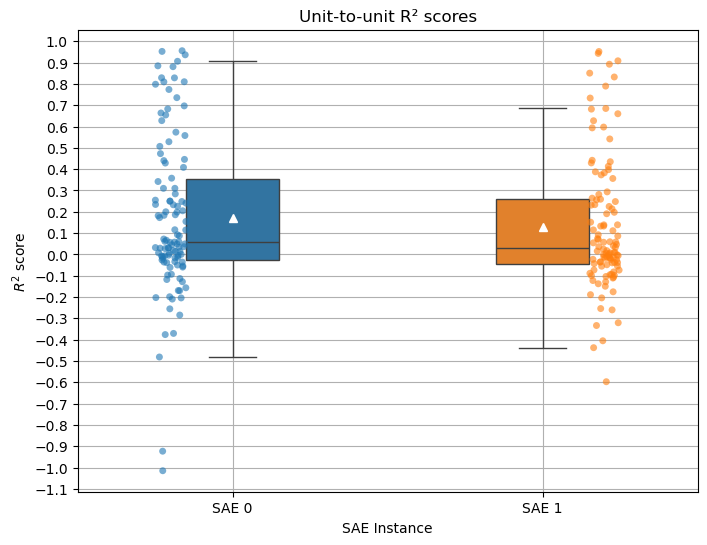

In [33]:
"""Calculate var explained for each neuron."""

r2_neuron = np.empty((n_inst, n_units))
for inst in range(n_inst):
    for unit in range(n_units):
        r2_neuron[inst, unit] = r2_score(
            asnumpy(spike_counts[0:n_recon_examples, unit].float()),
            asnumpy(recon_spk_cts[:, inst, unit].float())
        )

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(
    data=[r2_neuron[i] for i in range(n_inst)],
    width=0.3,
    showfliers=False,
    showmeans=True,
    meanprops={
        "markeredgecolor": "white",
        "markerfacecolor": "white",
        "markersize": "6"
    },
    ax=ax
)
sns.stripplot(
    data=[r2_neuron[i] for i in range(n_inst)],
    alpha=0.6,
    jitter=True,
    dodge=True,
    ax=ax,
)

# Customize the plot labels and title
ax.set_xlabel("SAE Instance")
ax.set_ylabel("$R^2$ score")
ax.set_title("Unit-to-unit R² scores")
ax.set_xticklabels([f"SAE {i}" for i in range(n_inst)])
ax.set_yticks(np.arange(-1.1, 1.1, 0.1))
ax.grid(True)

In [34]:
"""Calculate cosine similarity between recon and actual for each exmample."""

batch_sz = 128
n_steps = spike_counts.shape[0] // batch_sz
n_recon_examples = n_steps * batch_sz
cos_sim = t.empty((n_recon_examples, n_inst)).to(device)

# This requires too mach memory, so we have to batch it.
# for inst in range(n_inst):
#   cos_sim[:, inst] = F.cosine_similarity(
#       rearrange(spike_counts[0:n_recon_examples], "example unit -> example 1 unit"),
#       recon_spk_cts[:, inst, :],
#       dim=2,
#   )

pbar = tqdm(range(n_steps))
for step in pbar:
    # Get proper indices corresponding to step
    idxs = t.arange(step * batch_sz, (step + 1) * batch_sz)
    cos_sim[idxs, :] = t.cosine_similarity(
        repeat(spike_counts[idxs, :], "example unit -> example inst unit", inst=n_inst),
        recon_spk_cts[idxs, :, :],
        dim=2
    ).float()

cos_sim = asnumpy(cos_sim)

  0%|          | 0/735 [00:00<?, ?it/s]

(0.4, 1.0)

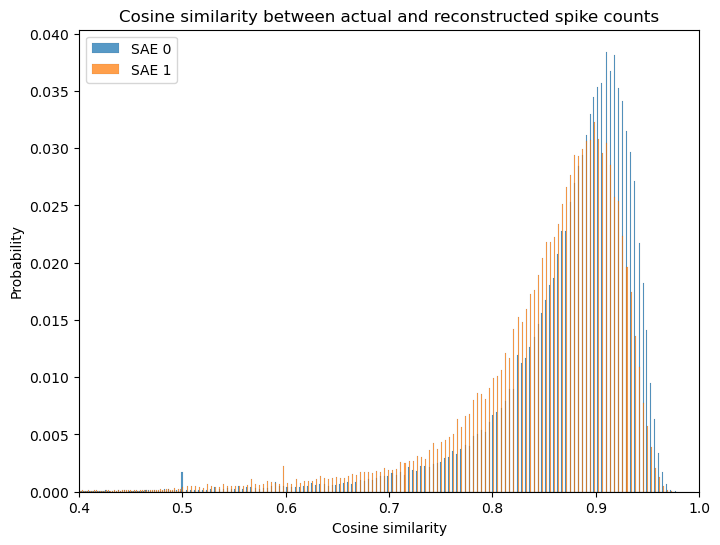

In [35]:
"""Plot cosine similarities."""

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    sns.histplot(cos_sim[:, inst], bins=1000, stat="probability", ax=ax, label=f"SAE {inst}")

ax.set_xlabel("Cosine similarity")
ax.set_ylabel("Probability")
ax.set_title("Cosine similarity between actual and reconstructed spike counts")
ax.legend(["SAE 0", "SAE 1"])
ax.set_xlim(0.4, 1.0)

## Validate SAE features

Essentially create a confusion matrix for natural vs. sae feature: for all occurrences of natural feature, see co-occurrence rate of top-responding sae features; for all occurrences of sae feature, see co-occurrence rate of natural feature

In [36]:
"""Get all times of light flashes, rank features by mean activation value."""

all_flashes = session_stim_data[session_stim_data["stimulus_name"] == "flashes"]
light_flashes = all_flashes[all_flashes["color"] > 0]
flash_times_light = []
for _, row in light_flashes.iterrows():
    cur_stim_times = np.unique(np.arange(row["start_time"], row["stop_time"], win).round(round_to))
    flash_times_light.extend(cur_stim_times)
counts_flash_df = counts_df.loc[flash_times_light]
spk_cts_l_f = t.from_numpy(counts_flash_df.values).bfloat16().to(device)

feat_flash_acts = t.empty(
    (len(counts_flash_df), n_inst, sae.cfg.n_hidden_ae), dtype=t.bfloat16, device=device
)

batch_sz = 32
n_steps = len(counts_flash_df) // batch_sz
pbar = tqdm(range(n_steps))

with t.no_grad():
    for step in pbar:
        idxs = t.arange(step * batch_sz, (step + 1) * batch_sz)
        idxs = repeat(idxs, "batch -> batch inst", inst=n_inst)
        seq_idxs = idxs.unsqueeze(-1) + t.arange(seq_len)
        spike_count_seqs = spk_cts_l_f[seq_idxs]
        spike_count_seqs = rearrange(
            spike_count_seqs, "batch inst seq unit -> (batch seq) inst unit"
        )
        _l1_loss, _l2_loss, _loss, z, _x_prime = sae.forward(spike_count_seqs)
        feat_flash_acts[idxs[:, 0]] = z

feat_flash_acts_mean = reduce(feat_flash_acts, "example inst hidden_ae -> inst hidden_ae", "mean")

k = 2
topk_feat_vals, topk_feat_idxs = feat_flash_acts_mean.topk(k)

topk_feat_idxs = asnumpy(topk_feat_idxs)
feat_flash_acts = asnumpy(feat_flash_acts.float())

  0%|          | 0/7 [00:00<?, ?it/s]

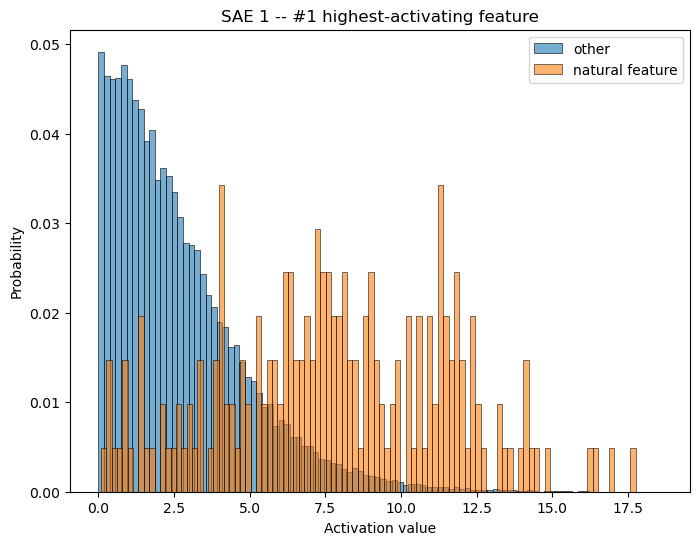

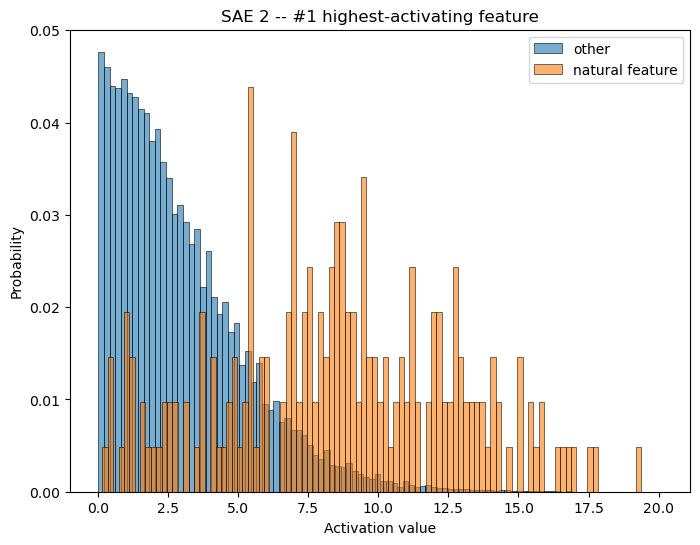

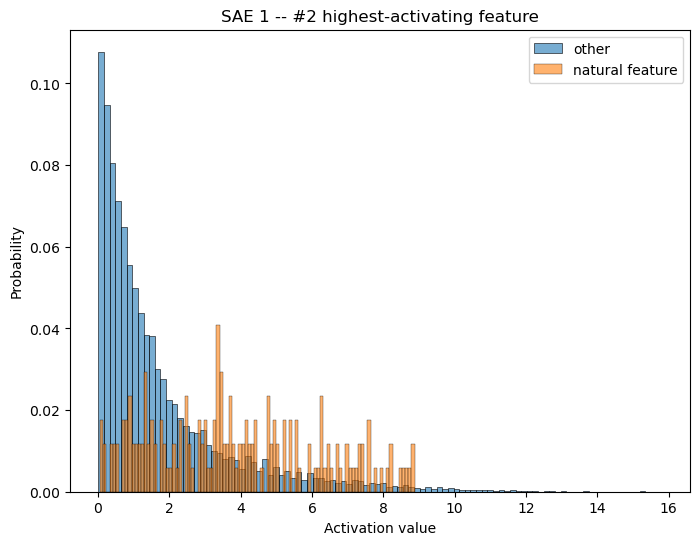

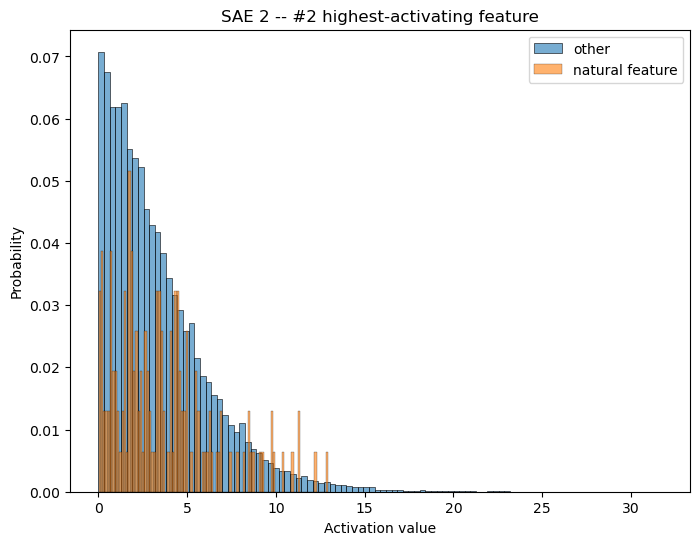

In [37]:
"""Visualize activations."""

# For topk features, plot histogram of activation values at all nonflash times, overlaid by a
# histogram of activation values at flash times.
flash_idxs = np.where(np.isin(counts_df.index.values, counts_flash_df.index.values))[0]
for k_i in range(k):
    for inst in range(n_inst):
        cur_feat_nonflash_acts = all_acts[:, inst, topk_feat_idxs[inst, k_i]].copy()
        cur_feat_nonflash_acts[flash_idxs] = 0.0  # zero out activations at flash times
        cur_feat_nonflash_acts = cur_feat_nonflash_acts[cur_feat_nonflash_acts > 1e-2]
        cur_feat_flash_acts = feat_flash_acts[:, inst, topk_feat_idxs[inst, k_i]]
        cur_feat_flash_acts = cur_feat_flash_acts[cur_feat_flash_acts > 1e-2]
        
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.histplot(
            cur_feat_nonflash_acts,
            bins=100,
            stat="probability",
            alpha=0.6,
            label="other",
            ax=ax,
        )
        sns.histplot(
            cur_feat_flash_acts,
            bins=100,
            stat="probability",
            alpha=0.6,
            label="natural feature",
            ax=ax,
        )
        ax.set_xlabel("Activation value")
        ax.set_title(f"SAE {inst + 1} -- #{k_i + 1} highest-activating feature")
        ax.legend()


              precision    recall  f1-score   support

       False       1.00      1.00      1.00     93925
        True       0.85      0.81      0.83       225

    accuracy                           1.00     94150
   macro avg       0.93      0.90      0.92     94150
weighted avg       1.00      1.00      1.00     94150



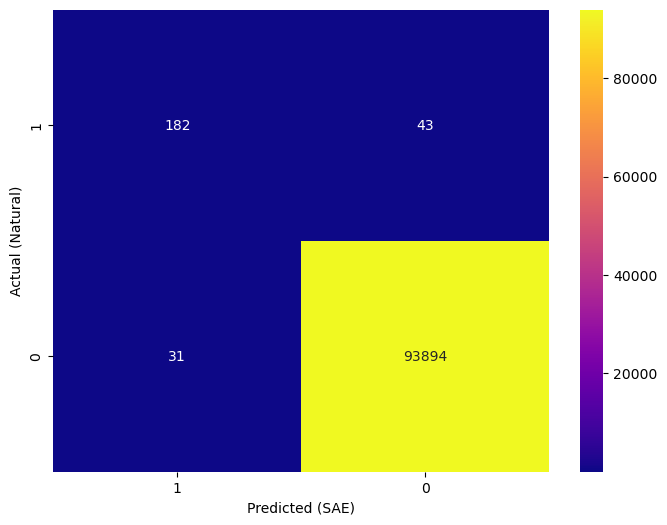

In [ ]:
"""Create a confusion matrix for sae-natural feature co-occurrence."""

# For each time the sae feature ("predicted" class) fires above a threshold activation value, 
# see how often the natural feature ("actual" class) is present, and vice versa.

act_thresh = 12
sae_feat_acts_mask = all_acts[:, 0, topk_feat_idxs[0, 0]] > act_thresh
sae_feat_times = counts_df.index.values[0:len(sae_feat_acts_mask)][sae_feat_acts_mask]
nat_feat_times = counts_flash_df.index.values
all_times = counts_df.index.values

nat_present = np.isin(all_times, nat_feat_times)
sae_present = np.isin(all_times, sae_feat_times)
cm = np.flip(confusion_matrix(nat_present, sae_present))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,
    fmt="d",  # as int
    cmap="plasma",  # Color map
    xticklabels=["1", "0"],
    yticklabels=["1", "0"],
    ax=ax
)
ax.set_xlabel("Predicted (SAE)")
ax.set_ylabel("Actual (Natural)")

print(classification_report(nat_present, sae_present))

## Scratchpad below here

In [77]:
def batched_forward_pass(
    spike_counts: Int[Tensor, "n_examples n_units"],
    sae: Sae, 
    batch_sz: int, 
    seq_len: int, 
    device: str = "cuda"
) -> tuple[
    Int[Tensor, "n_examples n_inst"], 
    Float[Tensor, "n_examples n_inst n_units"], 
    Float[Tensor, "n_examples n_inst n_hidden_ae"],
    Float[Tensor, "n_examples n_inst"],
    Float[Tensor, "n_examples n_inst"],
    Float[Tensor, "n_examples n_inst"]
]:
    """Perform batched forward pass through SAE model.
    
    Returns a tuple containing:
        - L0 (number of active features per example)
        - Reconstructed spike counts per example
        - Hidden layer activations per example
        - L1 loss per example
        - L2 loss per example
        - Total loss per example
    """
    # Initialize batches.
    n_examples, n_units = spike_counts.shape[0], spike_counts.shape[1]
    n_inst = sae.cfg.n_instances
    n_full_batches, final_batch_sz = n_examples // batch_sz, n_examples % batch_sz
    n_steps = n_full_batches + (1 if final_batch_sz > 0 else 0)
    
    # Initialize output tensors.
    l0 = t.zeros((n_examples, n_inst), dtype=t.float32, device=device)
    recon_spk_cts = t.empty((n_examples, n_inst, n_units), dtype=t.bfloat16, device=device)
    h_acts = t.empty((n_examples, n_inst, sae.cfg.n_hidden_ae), dtype=t.bfloat16, device=device)
    l1_losses = t.empty((n_examples, n_inst), dtype=t.bfloat16, device=device)
    l2_losses = t.empty((n_examples, n_inst), dtype=t.bfloat16, device=device)
    total_losses = t.empty((n_examples, n_inst), dtype=t.bfloat16, device=device)
    
    progress_bar = tqdm(range(n_steps))
    with t.no_grad():
        for step in progress_bar:
            # Set up for forward pass.
            cur_batch_size = batch_sz if step < n_full_batches else final_batch_sz
            start_idx = step * batch_sz
            end_idx = start_idx + cur_batch_size
            idxs = t.arange(start_idx, end_idx)
            idxs = repeat(idxs, "batch -> batch inst", inst=n_inst)
            # broadcast idxs for each sequence to a new dimension
            seq_idxs = idxs.unsqueeze(-1) + t.arange(seq_len)
            spike_count_seqs = spike_counts[seq_idxs]
            spike_count_seqs = rearrange(
                spike_count_seqs, "batch inst seq unit -> (batch seq) inst unit"
            )
            
            # Compute reconstructions, hidden layer activations, and losses.
            l1_loss, l2_loss, loss, z, x_prime = sae.forward(spike_count_seqs)
            
            # Compute L0.
            nonzero_mask = (z.abs() > 1e-7).float()
            cur_l0 = reduce(nonzero_mask, "batch inst sae_feat -> batch inst", "sum")
            
            # Store results
            l0[idxs[:, 0]] = cur_l0
            recon_spk_cts[idxs[:, 0]] = x_prime
            h_acts[idxs[:, 0]] = z
            l1_losses[idxs[:, 0]] = l1_loss
            l2_losses[idxs[:, 0]] = l2_loss
            total_losses[idxs[:, 0]] = loss
    
    return l0, recon_spk_cts, h_acts, l1_losses, l2_losses, total_losses